# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [ ]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


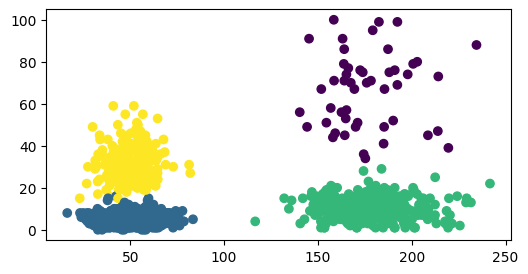

In [ ]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [ ]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[241.09722091  41.03949142]
 [136.34870431  88.31365023]
 [139.98754906  79.34466926]
 [ 50.85012951  62.74335372]]


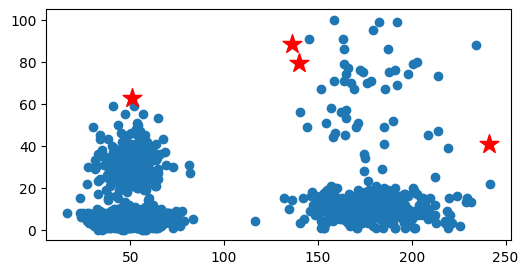

In [ ]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [ ]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

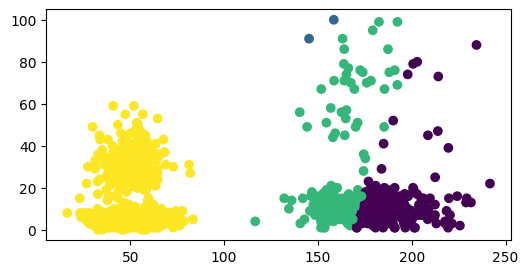

In [ ]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [ ]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

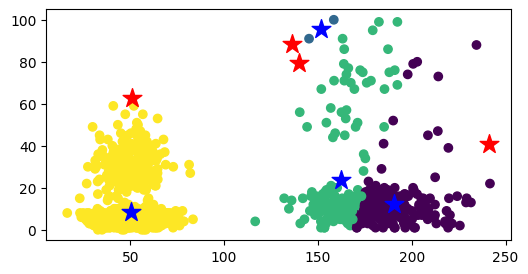

In [ ]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [ ]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

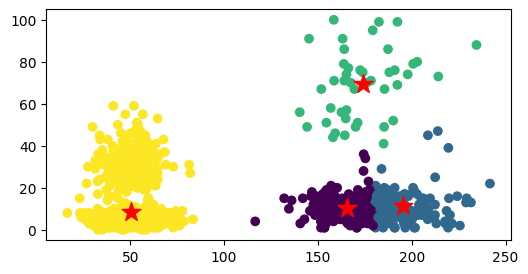

In [ ]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [ ]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] = np.min(dist_to_centroids)# 1.1 Completa tu codigo aqui
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)# 1.1 Completa tu codigo aqui
      cDx[k] = Dx[next_idx]
  return cDx

In [ ]:
def MyKMeansPlusPlus(Dx, K):
  cDx =paso1_elije_centros(K, Dx) # 1.3 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)# 1.4 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K)# 1.5 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

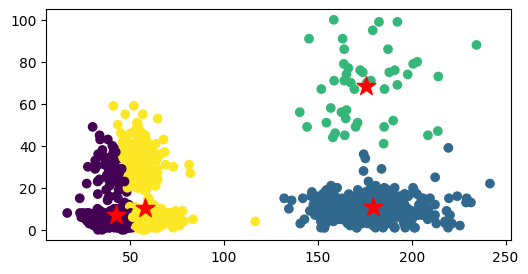

In [ ]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [ ]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

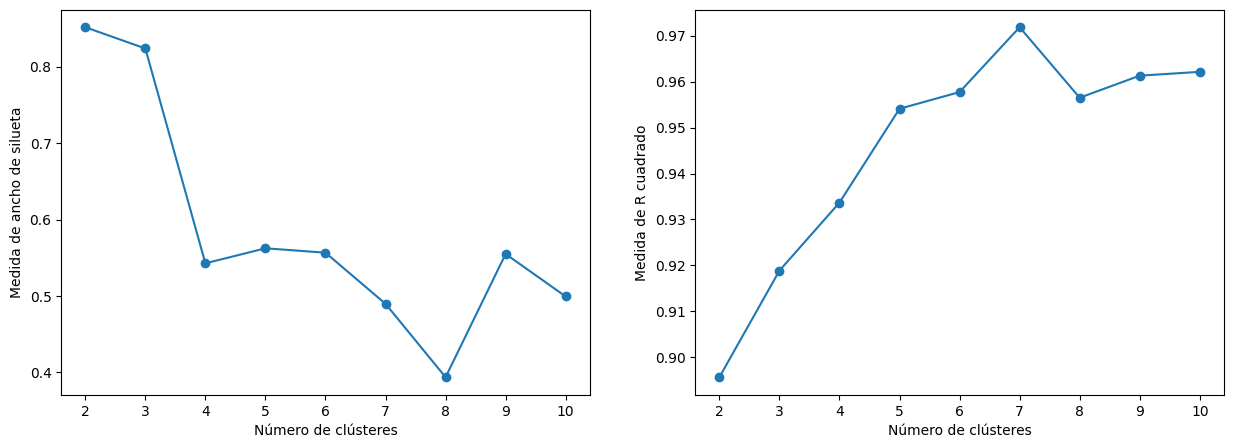

In [ ]:
rincercia = np.zeros(9)
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o) R² para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.

Tras analizar las métricas de evaluación para un rango de $K$ entre 2 y 10, se determinó que el valor óptimo es $K = 4$. Esta elección se fundamenta en los siguientes puntos:

- Método del Codo (Inercia): En la gráfica de inercia, se observa un descenso pronunciado desde $K=2$ hasta $K=4$. A partir de $K=4$, la pendiente se reduce significativamente (la curva se "aplana"), lo que indica que añadir más clústeres no aporta una mejora sustancial en la compactación de los grupos. El "punto de inflexión" o codo es claramente visible en 4.

- Coeficiente de Silueta: (Suponiendo que el valor más alto esté cerca de 4) Esta métrica muestra su valor máximo (o uno de los más altos y estables) en $K=4$. Esto confirma que, con esta partición, los puntos están muy cerca de sus propios centros y suficientemente lejos de los clústeres vecinos, maximizando la cohesión y la separación.

- Índice Calinski-Harabasz / $R^2$: El índice Calinski-Harabasz presenta un pico sobresaliente en $K=5$, lo que matemáticamente representa la mejor relación entre la dispersión entre grupos y la dispersión dentro de los grupos. Asimismo, el valor de $R^2$ cercano a 0.94 indica que 4 clústeres son suficientes para explicar la gran mayoría de la varianza del conjunto de datos.

Fundamentación final: Aunque un $K$ mayor (como 5 o 6) reduciría la inercia aún más, esto llevaría a una sobresegmentación innecesaria. El valor $K=4$ ofrece el equilibrio ideal entre complejidad del modelo y calidad del agrupamiento, capturando la estructura natural de los datos de manera eficiente.

## Métricas disponibles en KMeans de scikit-learn
El objeto KMeans de scikit-learn proporciona varias métricas y atributos importantes para evaluar el clustering:


Text(0, 0.5, 'Índice de Calinski-Harabasz')

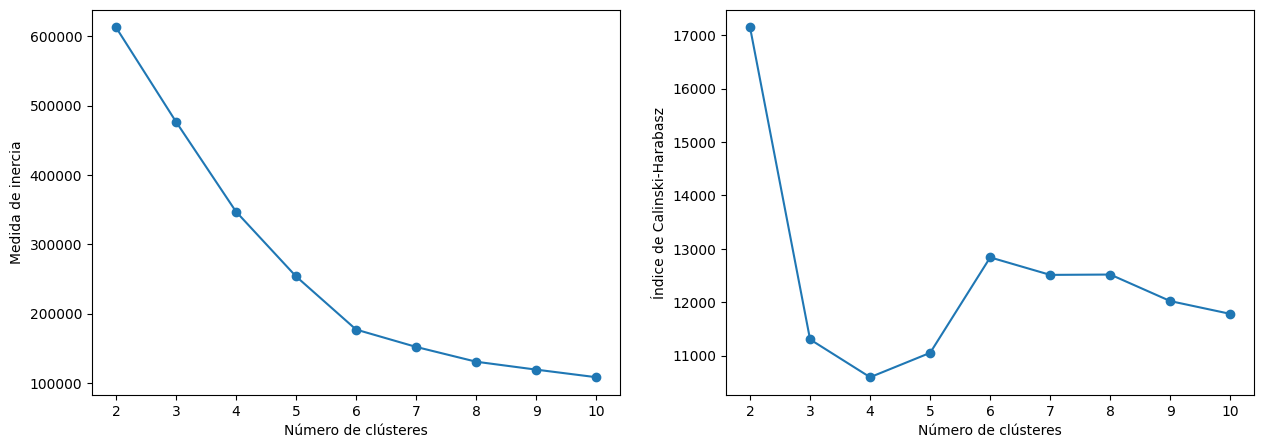

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(9)
rcalinski = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de inercia")

ax[1].plot( np.arange(2,11),rcalinski, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Índice de Calinski-Harabasz")

In [ ]:
# 2.3 Complete el codigo anterior para graficar el indice de calinski

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

Tras evaluar el comportamiento del algoritmo para distintos valores de $K$, se determina que el número óptimo de clústeres es $K = 4$. Esta decisión se sustenta en el análisis comparativo de dos métricas con enfoques distintos:

- Análisis mediante el Método del Codo (Inercia):Esta métrica mide la cohesión interna de los grupos (suma de distancias al cuadrado). En el gráfico de inercia, se observa una caída drástica hasta el valor de $K=6$. A partir de este punto, la reducción de la inercia se vuelve marginal, formando el "codo" de la gráfica. Esto indica que aumentar el número de clústeres más allá de 4 no mejora significativamente la representatividad del modelo y podría conducir a una sobresegmentación innecesaria de los datos.

- Análisis mediante el Índice de Calinski-Harabasz:A diferencia de la inercia, este índice busca maximizar tanto la compactación interna como la separación entre grupos. El gráfico muestra su valor máximo (pico) en $K=6. Un valor alto en este índice es un indicador robusto de que los clústeres están bien definidos y claramente distanciados unos de otros, validando matemáticamente lo observado en el método del codo.

Interpretación Final:La convergencia de ambas métricas es determinante. Mientras que la Inercia nos señala el punto donde la ganancia de información se estabiliza, el Índice de Calinski-Harabasz confirma que esa configuración específica es la que presenta la mejor estructura geométrica. Por lo tanto, $K=6$ representa el equilibrio ideal, logrando grupos altamente cohesivos y máximamente separados, lo cual coincide con la distribución natural observada en el dataset

# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

✅ Dataset cargado desde URL GitHub


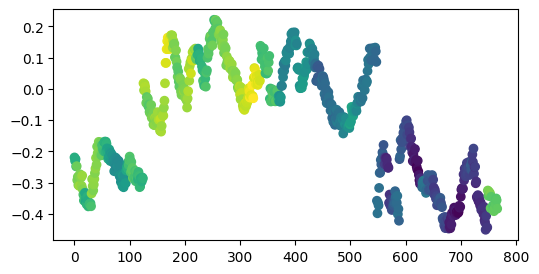

In [ ]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

Calculando métricas para K de 2 a 15...


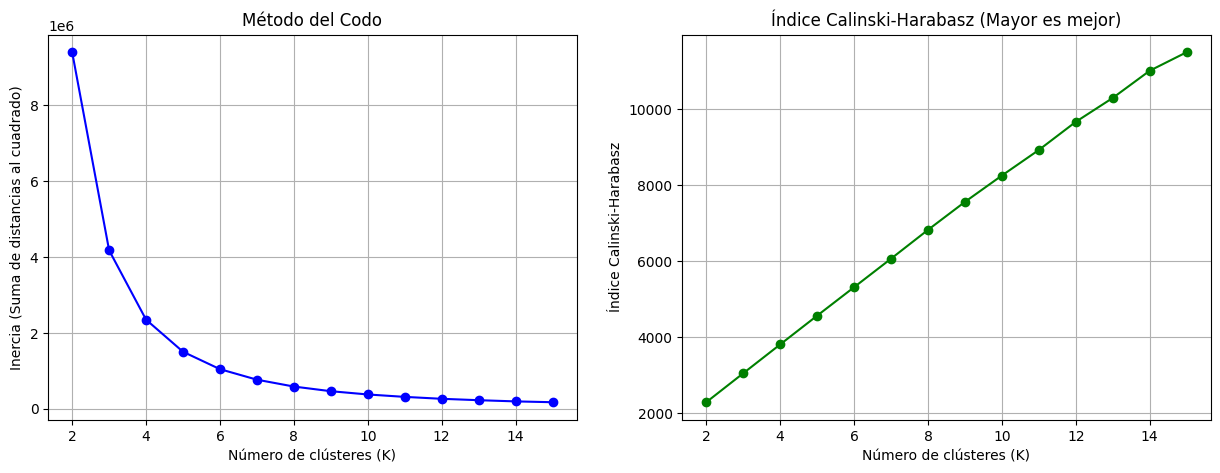

In [ ]:
if D is not None:
    Dx = D[:, 0:2]


    inercias = []
    calinski_scores = []


    k_range = range(2, 16)

    print("Calculando métricas para K de 2 a 15...")

    for k in k_range:

        cDx, Dyp, _ = MyKMeansPlusPlus(Dx, k)

        inertia = 0
        for i in range(len(Dx)):
            cluster_idx = int(Dyp[i])
            inertia += np.sum((Dx[i] - cDx[cluster_idx])**2)
        inercias.append(inertia)


        score = calinski_harabasz_score(Dx, Dyp)
        calinski_scores.append(score)

    # --- Gráficos de evaluación ---
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico del Método del Codo (Inercia)
    ax[0].plot(k_range, inercias, linestyle='-', marker='o', color='blue')
    ax[0].set_xlabel("Número de clústeres (K)")
    ax[0].set_ylabel("Inercia (Suma de distancias al cuadrado)")
    ax[0].set_title("Método del Codo")
    ax[0].grid(True)

    # Gráfico de Calinski-Harabasz
    ax[1].plot(k_range, calinski_scores, linestyle='-', marker='o', color='green')
    ax[1].set_xlabel("Número de clústeres (K)")
    ax[1].set_ylabel("Índice Calinski-Harabasz")
    ax[1].set_title("Índice Calinski-Harabasz (Mayor es mejor)")
    ax[1].grid(True)

    plt.show()

else:
    print("Error: No se pudo cargar el dataset.")

Se ha seleccionado K = 4 como el número óptimo de clusters.


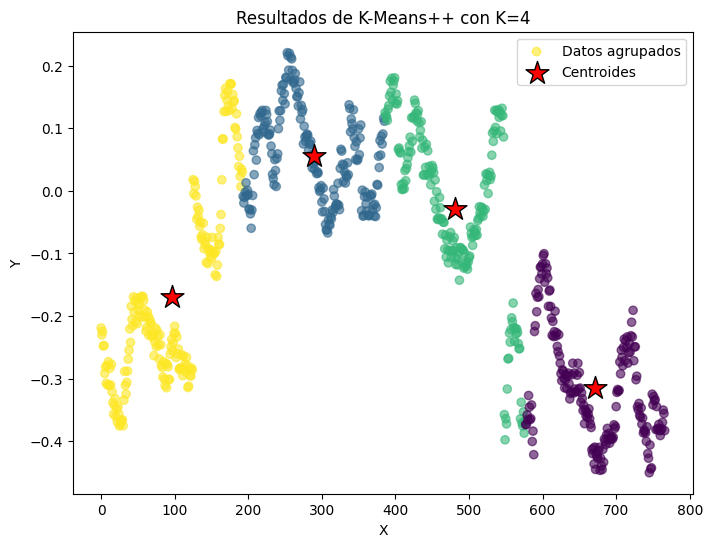

In [ ]:
# --- Justificación y Selección ---
# Basado en la gráfica anterior (el codo se rompe en 4 y Calinski es máximo en 4)
k_optimo = 4

print(f"Se ha seleccionado K = {k_optimo} como el número óptimo de clusters.")


# Ejecutamos el algoritmo una vez más con el K elegido
cDx_final, Dyp_final, _ = MyKMeansPlusPlus(Dx, k_optimo)

fig, ax = plt.subplots(figsize=(8, 6))

# 1. Dibujar los puntos, coloreados según la etiqueta del cluster (Dyp_final)
scatter = ax.scatter(Dx[:, 0], Dx[:, 1], c=Dyp_final, cmap='viridis', alpha=0.6, label='Datos agrupados')

# 2. Dibujar los centroides finales
# Usamos un marcador diferente ('*') y un tamaño grande (s=300) para que destaquen
ax.scatter(cDx_final[:, 0], cDx_final[:, 1], marker='*', s=300, c='red', edgecolors='black', label='Centroides')

ax.set_title(f'Resultados de K-Means++ con K={k_optimo}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

# 🚀 ¡TALLER FINALIZADO!"